# Zillow Regression Project

Christopher Mayorga - June 15, 2021

## Executive Summary

**Problem**
- The company is needing to predict home values of single unit properties in the Southern California area that the tax district assesses.

**Goal**
- My goal is to develop a linear regression based machine learning model that can accurately predict home values of single unit properties based on data from May-August of 2017.

**Process**
- Acquire the Data
- Prepare
- Explore
- Model
- Create Recommendations Based On Findings

**Findings**
- My choice of model (Lasso Lars Alpha=1) beats the baseline with an R^2 of 95% and an RMSE on the test data of 69,003 vs a baseline mean of 301,586.
- The bulk of the property data is for properties under $1.68 million dollars. my linear regression model begins to under value properties as the value increases over the upper threshold.

- More refinement, feature creation, and data will be needed to create a more honed in prediction model.



In [2]:
# packages for data analysis & mapping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from math import sqrt
import seaborn as sns
from datetime import date 



# modeling methods
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE 
import sklearn.preprocessing



# address warnings
import warnings
warnings.filterwarnings("ignore")

# acquire, prep, train, & explore functions
from wrangle import get_connection, new_zillow_data, get_zillow_data, clean_zillow, split_data, wrangle_zillow, train_validate_test, min_max_scale, get_object_cols, get_numeric_X_cols

## Acquire

In [3]:
# Acquire the data
df = get_zillow_data()

In [4]:
# See how many rows and columns there are
df.shape

(39696, 16)

In [5]:
# See if there are any null values
df.isna().sum()

parcelid                            0
propertylandusetypeid               0
propertylandusedesc                 0
unitcnt                         14719
transactiondate                     0
calculatedfinishedsquarefeet      114
bedroomcnt                          0
bathroomcnt                         0
fips                                0
regionidzip                        27
yearbuilt                         137
taxvaluedollarcnt                   1
latitude                            0
longitude                           0
assessmentyear                      0
taxamount                           1
dtype: int64

Based on this, we know that some rows will need to be dropped in the prepare stage.

**Let's check for outliers.**

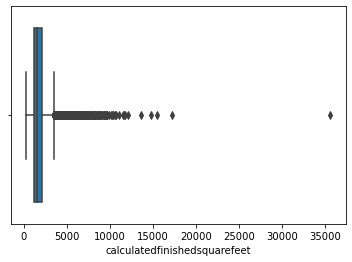

In [7]:
sns.boxplot(data = df, x = 'calculatedfinishedsquarefeet')
plt.show()

<AxesSubplot:xlabel='taxvaluedollarcnt'>

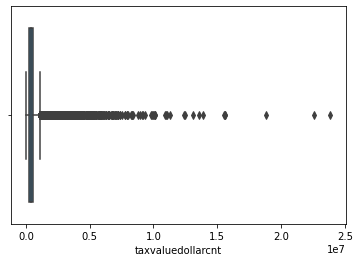

In [8]:
sns.boxplot(data = df, x = 'taxvaluedollarcnt')

In [10]:

q1, q3 = df.taxvaluedollarcnt.quantile([.25, .75])

iqr = q3 - q1

upperbound = q3 + 3.0 * iqr
lowerbound = q1 - 3.0 * iqr

print(f'The upper bound quartile is {upperbound} while our lower bound quartile is {lowerbound}. These outliers will be addressed in prep')

The upper bound quartile is 1679155.0 while our lower bound quartile is -888592.0. These outliers will be addressed in prep


**Outlier takeaways:**
- `calculatedfinishedsquarefeet` has some outliers but it might not matter much if we don't use it for modeling
- `taxvaluedollarcnt` , our target variable, has outliers as well. I'm deciding to remove any data points that fall above the upper bound quartile, which is about $1.8 million.

## Prepare

In [16]:
df = clean_zillow(df)

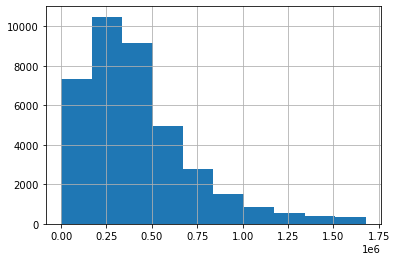

In [17]:
df.tax_assessed_value.hist()
plt.show()

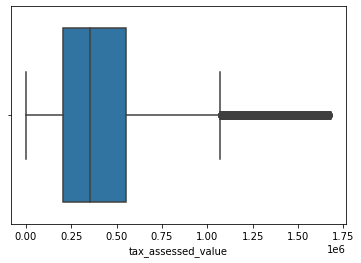

In [18]:
sns.boxplot(data = df, x = 'tax_assessed_value')
plt.show()

Notice how tax value is much less right skewed now that we've removed outliers.

## Explore

In [19]:
df = wrangle_zillow()
train, validate, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df, 'tax_assessed_value')

In [25]:
quant_vars = ['total_sqft', 'bedroom_quanity', 'bathroom_quanity', 'tax_assessed_value', 'age_of_home', 'latitude', 'longitude', 'fips']


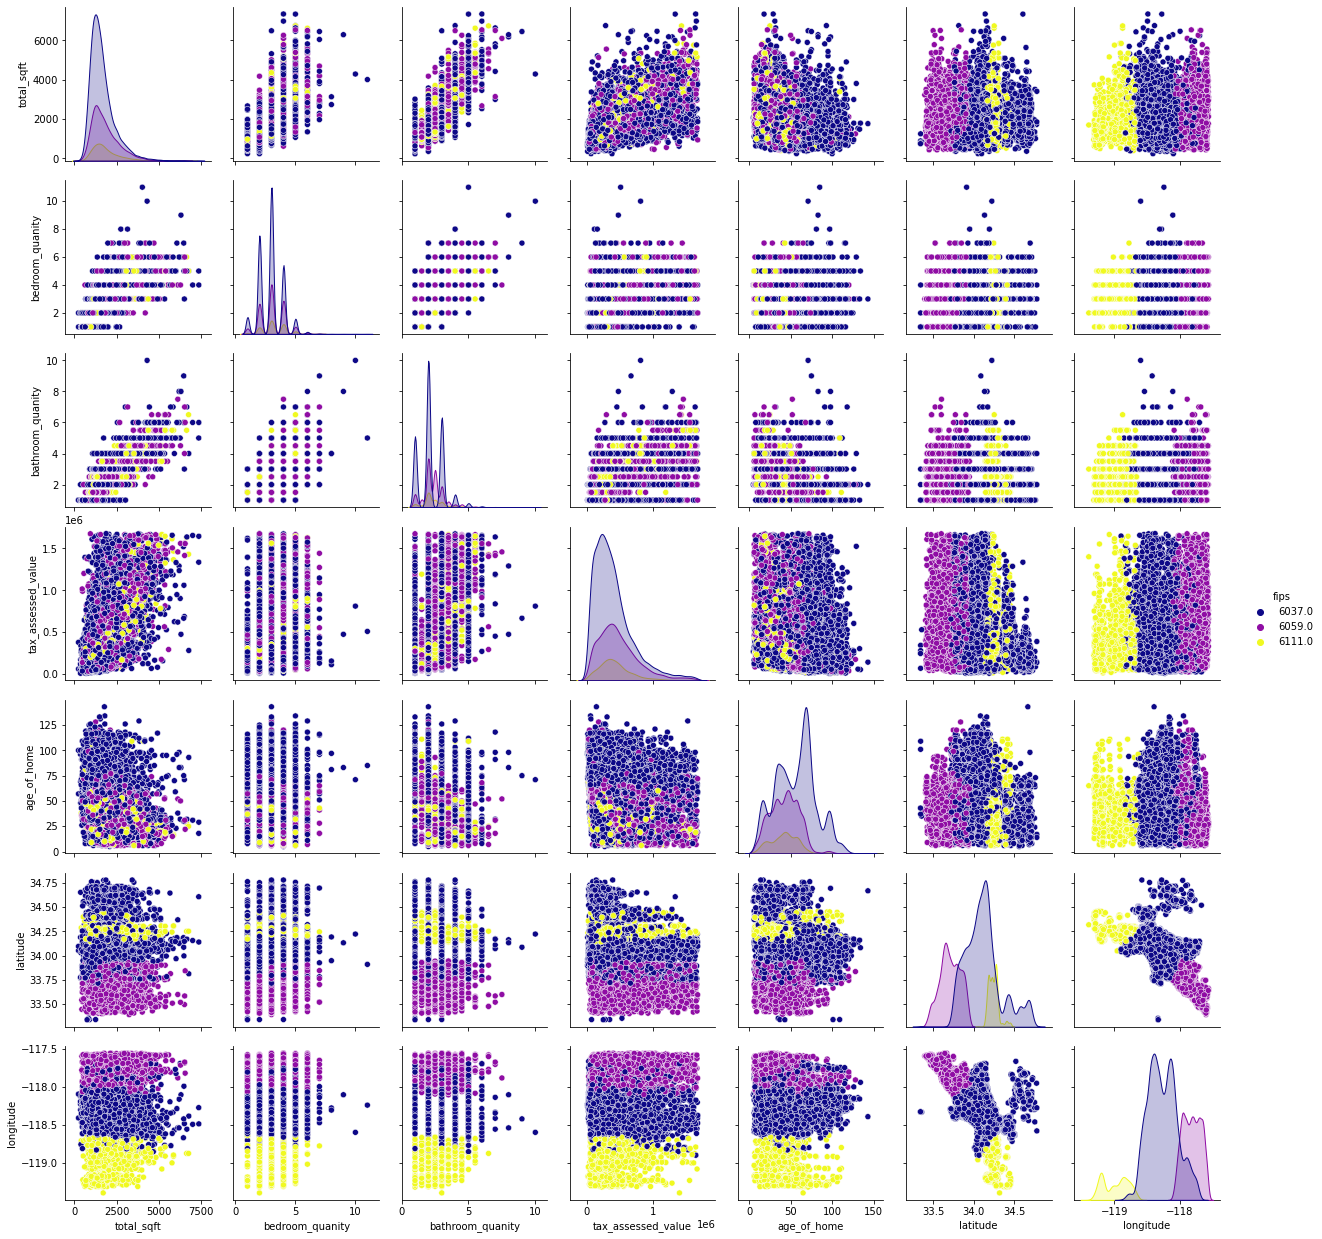

In [27]:
sns.pairplot(data = train[quant_vars], hue = 'fips', palette='plasma')

**Pairplot takeaways:**
- Possible correlation between tax value and bathroom count
- Possible correlation between tax value and total square feet
- Some independent variables may have a relationship with each other, like bedroom count and total square feet

<AxesSubplot:>

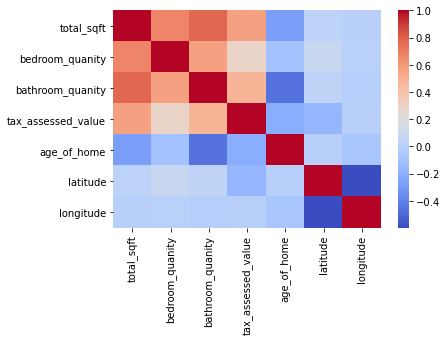

In [29]:
sns.heatmap(data = df[quant_vars].corr(), cmap='coolwarm')

**Heatmap takeawys:**
- Bathroom count and total square feet stick out again as potentially having a relationship with tax value
- Seems like there is a strong correlation between bedroom/bathroom count and total square feet

### Correlation tests

In [33]:
# Set Confidence Interval and Alpha; check alpha.

confidence_interval = .95
alpha = round(1 - confidence_interval, 2)
a = round(1 - confidence_interval, 2)
print(f'alpha = {alpha}')

alpha = 0.05


Was this by chance?

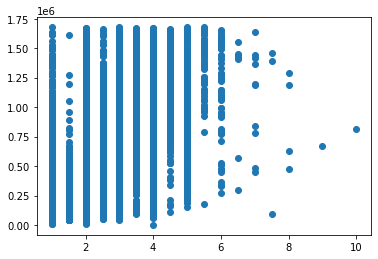

In [32]:
plt.scatter(df.bathroom_quanity, df.tax_assessed_value)

Null hypothesis: There is no relationship between bathroom quantity and tax value.<br>
Alternative hypothesis: There is a relationship between bathroom quantity and tax value.

In [35]:
corr, p = stats.pearsonr(df.bathroom_quanity, df.tax_assessed_value)
corr, p

(0.4847885428779892, 0.0)

We can reject the null hypothesis. We have evidence to suggest there is a relationship between bathroom quantity and tax value.

Was this by chance?

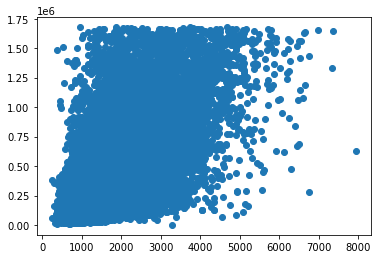

In [31]:
plt.scatter(df.total_sqft, df.tax_assessed_value)

Null hypothesis: There is no relationship between total square feet and tax value.<br>
Alternative hypothesis: There is a relationship between total square feet and tax value.

In [36]:
corr, p = stats.pearsonr(df.total_sqft, df.tax_assessed_value)
corr, p

(0.5707560067443509, 0.0)

We can reject the null hypothesis. We have evidence to suggest there is a relationship between total square feet and tax value.

### T Test

FIPS is a federal identifier for counties.
- 6037 - Los Angeles County, California
- 6059 - Orange County, California
- 6111 - Ventura County, California

Does Los Angeles County have more bathrooms per sqft than Orange County?

In [37]:
null_hypothesis = "Los Angeles County does not have more bathrooms per sqft than Orange County"
alternative_hypothesis = "Los Angeles County does have more bathrooms per sqft than Orange County"
confidence_level = .95
alpha = 1 - confidence_level 

In [38]:
la_fips = train[train.fips == 6037]
oc_fips = train[train.fips == 6059]

In [39]:
t, p = stats.ttest_ind(la_fips.bath_pers_qft, oc_fips.bath_pers_qft)
t, p

(3.950145690050238, 7.837682641343573e-05)

In [40]:
if (p/2) < a and t > 0:
    print("We reject the null hypothesis that", null_hypothesis) 
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Failing to reject the null != 'accepting the null'")

We reject the null hypothesis that Los Angeles County does not have more bathrooms per sqft than Orange County
We move forward with the alternative hypothesis that Los Angeles County does have more bathrooms per sqft than Orange County


### Scaling the data

In [41]:
object_cols = get_object_cols(df)
numeric_cols = get_numeric_X_cols(X_train, object_cols)

In [42]:
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, X_validate, X_test, numeric_cols)

### Feature engineering

In [43]:
def select_kbest(x, y, k):
    
    # parameters: f_regression stats test, give me 8 features
    f_selector = SelectKBest(f_regression, k=k)
    
    # find the top 8 X's correlated with y
    f_selector.fit(X_train_scaled, y_train)
    
    # boolean mask of whether the column was selected or not. 
    feature_mask = f_selector.get_support()
    
    f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
    
    return f_feature

In [44]:
select_kbest(X_train_scaled, 'tax_assessed_value', 4)

['total_sqft', 'bathroom_quanity', 'property_tax', 'beds_pers_qft']

In [45]:
def rfe(x, y, k):
    
    lm = LinearRegression()
    
    rfe = RFE(lm, k)
    
    # Transforming data using RFE
    X_rfe = rfe.fit_transform(X_train_scaled,y_train)  
    
    mask = rfe.support_
    
    rfe_features = X_train_scaled.loc[:,mask].columns.tolist()
    
    print(str(len(rfe_features)), 'selected features')
    
    return  rfe_features

In [46]:
rfe(X_train_scaled, 'tax_assessed_value', 4)

4 selected features


['total_sqft', 'bathroom_quanity', 'latitude', 'property_tax']

**Takeaways:**
- Best features for model seem to be the following
    - `total_sqft`
    - `bathroom_quanity`
    - `beds_pers_qft`
    - `latitude`
    - `property_tax`

## Model

### Setting the baseline

In [53]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict testscr_pred_mean
value_pred_mean = y_train.tax_assessed_value.mean()
y_train['value_pred_mean'] = value_pred_mean
y_validate['value_pred_mean'] = value_pred_mean

# 2. compute testscr_pred_median
value_pred_median = y_train.tax_assessed_value.median()
y_train['value_pred_median'] = value_pred_median
y_validate['value_pred_median'] = value_pred_median

# 3. RMSE of testscr_pred_mean
rmse_train = mean_squared_error(y_train.tax_assessed_value, y_train.value_pred_mean) ** 0.5
rmse_validate = mean_squared_error(y_validate.tax_assessed_value, y_validate.value_pred_mean) ** 0.5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of testscr_pred_median
# rmse_train = mean_squared_error(y_train.tax_assessed_value, y_train.value_pred_median) ** .5
# rmse_validate = mean_squared_error(y_validate.tax_assessed_value, y_validate.value_pred_median) ** .5
# print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      # "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


RMSE using Mean
Train/In-Sample:  300525.05 
Validate/Out-of-Sample:  301586.21


Mean's RMSE is lower so let's use mean as the baseline.

In [55]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_assessed_value, y_validate.value_pred_mean)}])

In [56]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,301586.212989,2.220446e-16


### Linear Regression Model

In [57]:
# create the model object
# 
# make the thing
# 
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm.fit(X_train, y_train.tax_assessed_value)

# predict train
# 
# use the thing!
# 
y_train['tav_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_assessed_value, y_train.tav_pred_lm) ** (1/2)
# predict validate
y_validate['tav_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_assessed_value, y_validate.tav_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  76178.60812875464 
Validation/Out-of-Sample:  74929.3701676475


In [59]:
metric_df = metric_df.append(
    {
    'model': 'OLS lm 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_assessed_value, y_validate.tav_pred_lm)}, ignore_index=True)

In [60]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,301586.212989,2.220446e-16
1,OLS lm 1,74929.370168,9.383376e-01


### Lasso Lars Model

In [61]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.tax_assessed_value)

# predict train
y_train['tav_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_assessed_value, y_train.tav_pred_lars) ** (1/2)

# predict validate
y_validate['tav_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_assessed_value, y_validate.tav_pred_lars) ** (1/2)

print("RMSE for Lasso Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  75946.46892033116 
Validation/Out-of-Sample:  74680.69968343718


In [63]:
metric_df = metric_df.append(
    {
    'model': 'LassoLars alpha 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_assessed_value, y_validate.tav_pred_lars)}, ignore_index=True)

In [64]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,301586.212989,2.220446e-16
1,OLS lm 1,74929.370168,9.383376e-01
2,LassoLars alpha 1,74680.699683,9.386559e-01


### Tweedie Regressor

In [65]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_assessed_value)

# predict train
y_train['tav_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_assessed_value, y_train.tav_pred_glm) ** (1/2)

# predict validate
y_validate['tav_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_assessed_value, y_validate.tav_pred_glm) ** (1/2)

print("RMSE for OLS using TweedieRegressor\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  300525.0483855948 
Validation/Out-of-Sample:  301586.2129887723


In [66]:
metric_df = metric_df.append(
    {
    'model': 'GLM Model Power 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_assessed_value, y_validate.tav_pred_glm)}, ignore_index=True)

In [67]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,301586.212989,2.220446e-16
1,OLS lm 1,74929.370168,9.383376e-01
2,LassoLars alpha 1,74680.699683,9.386559e-01
3,GLM Model Power 1,301586.212989,0.000000e+00


### Polynomial Regression

In [68]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [70]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_assessed_value)

# predict train
y_train['tav_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_assessed_value, y_train.tav_pred_lm2) ** (1/2)

# predict validate
y_validate['tav_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_assessed_value, y_validate.tav_pred_lm2) ** (1/2)

print("RMSE for Quadratic Model\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Quadratic Model
Training/In-Sample:  63913.18753586968 
Validation/Out-of-Sample:  98386.3265876701


In [71]:
metric_df = metric_df.append(
    {
    'model': 'Quadratic Model',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_assessed_value, y_validate.tav_pred_lm2)}, ignore_index=True)

In [72]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,301586.212989,2.220446e-16
1,OLS lm 1,74929.370168,9.383376e-01
2,LassoLars alpha 1,74680.699683,9.386559e-01
3,GLM Model Power 1,301586.212989,0.000000e+00
4,Quadratic Model,98386.326588,8.935426e-01


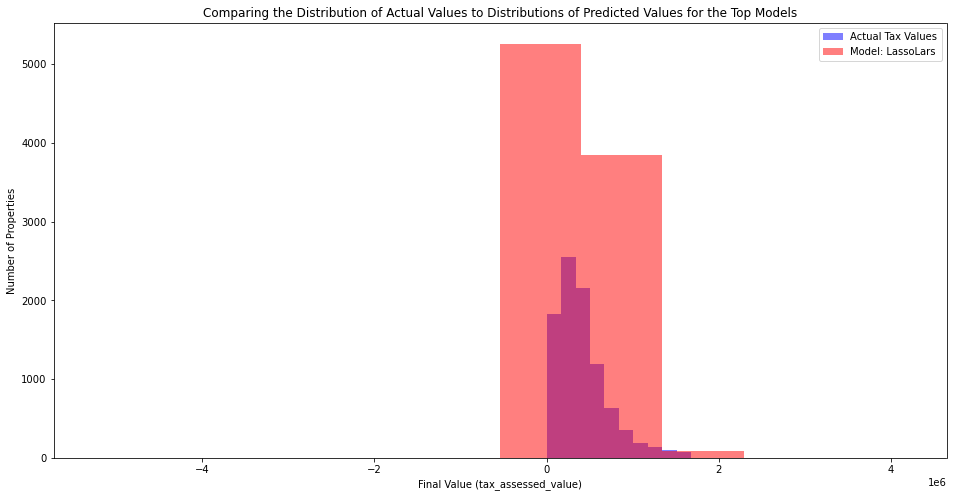

In [73]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_assessed_value, color='blue', alpha=.5, label="Actual Tax Values")
plt.hist(y_validate.tav_pred_lm2, color='red', alpha=.5, label="Model: LassoLars")
# plt.hist(y_validate.G3_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
# plt.hist(y_validate.G3_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Final Value (tax_assessed_value)")
plt.ylabel("Number of Properties")
plt.title("Comparing the Distribution of Actual Values to Distributions of Predicted Values for the Top Models")
plt.legend()
plt.show()

### **Lasso lars wins!**

**Model Selection & Out-of-Sample Evaluation**<br>
Model selected: LassoLars alpha 1

In [74]:
type(y_test)

pandas.core.series.Series

In [75]:
y_test = pd.DataFrame(y_test)

In [76]:
y_test.head()

,tax_assessed_value
parcelid,
12396415,79549.0
11119770,734386.0
11296286,165465.0
12910900,424247.0
14123956,71445.0


In [77]:
X_test.head()

,total_sqft,bedroom_quanity,bathroom_quanity,fips,zip_code,year_built,latitude,longitude,property_tax,age_of_home,bath_pers_qft,beds_pers_qft
parcelid,,,,,,,,,,,,
12396415,1267.0,3.0,1.0,6037,96197,1949,33.975147,-118.088966,1520.59,72,0.000789,0.002368
11119770,2508.0,4.0,3.0,6037,96377,1995,34.439893,-118.540868,10189.30,26,0.001196,0.001595
11296286,1933.0,3.0,3.0,6037,97318,1989,34.694153,-118.096315,2764.68,32,0.001552,0.001552
12910900,1532.0,3.0,2.0,6037,96475,1960,34.096982,-117.848958,5185.36,61,0.001305,0.001958
14123956,1344.0,3.0,2.0,6059,96183,1969,33.853939,-118.039512,1052.18,52,0.001488,0.002232


In [78]:
lars

LassoLars(alpha=1)

In [79]:
# predict on test
y_test['tav_pred_lars'] = lars.predict(X_test)

In [80]:
# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_assessed_value, y_test.tav_pred_lars) ** 0.5
print("RMSE for Lasso Lars Alpha 1\nOut-of-Sample Performance: ", rmse_test)

RMSE for Lasso Lars Alpha 1
Out-of-Sample Performance:  69003.01039099575


In [82]:
# evalute: r^2
r2score_test = r2_score(y_test.tax_assessed_value, y_test.tav_pred_lars)
print("R^2 score for Lasso Lars Alpha 1\nOut-of-Sample Performance: ", r2score_test)

R^2 score for Lasso Lars Alpha 1
Out-of-Sample Performance:  0.9488298746782533


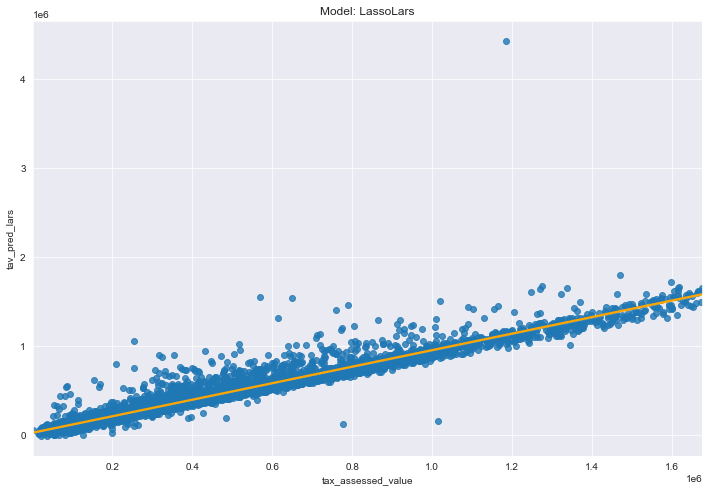

In [91]:
# visualize
plt.figure(figsize=(12,8))
plt.title("Model: LassoLars")
sns.set_style('darkgrid')
sns.regplot( x= y_validate.tax_assessed_value, y= y_validate.tav_pred_lars, line_kws={"color": "orange"}, 
             label="Model: LassoLars")

plt.show()

**Modeling takeaways:**
- Lasso Lars beat the baseline (Lars RMSE: 69003 vs Mean RMSE: 301586)
- Very high r^2 score of .95 on test dataframe
- All models beat the baseline except for TweedieRegressor

## Conclusions and Next Steps

While our current model is good, it could be improved greatly. I'm asking the Zillow data science team for feedback and any further input. This will help us in reaching our goal of predicting home values during the hot months in the coming years.

# Tax Rate Distributions By County

In [84]:
tax_df = clean_zillow(df)

In [85]:
tax_df['tax_rate'] = round(((tax_df['property_tax'] / tax_df['tax_assessed_value'])* 100),2)

In [86]:
tax_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38320 entries, 13083743 to 12473881
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_sqft          38320 non-null  float64
 1   bedroom_quanity     38320 non-null  float64
 2   bathroom_quanity    38320 non-null  float64
 3   fips                38320 non-null  object 
 4   zip_code            38320 non-null  object 
 5   year_built          38320 non-null  object 
 6   tax_assessed_value  38320 non-null  float64
 7   latitude            38320 non-null  float64
 8   longitude           38320 non-null  float64
 9   property_tax        38320 non-null  float64
 10  age_of_home         38320 non-null  int64  
 11  bath_pers_qft       38320 non-null  float64
 12  beds_pers_qft       38320 non-null  float64
 13  tax_rate            38320 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 4.4+ MB


In [87]:
tax_df.groupby('fips').tax_rate.median()

fips
6037.0    1.25
6059.0    1.16
6111.0    1.12
Name: tax_rate, dtype: float64

In [88]:
tax_df.groupby('fips').tax_assessed_value.median()

fips
6037.0    325215.5
6059.0    417076.5
6111.0    386023.5
Name: tax_assessed_value, dtype: float64

**Takeaways from Tax Rate Groupby:**
- Los Angeles County (6037) has the highest median tax rate at 1.25. Conversely, Ventura County (6111) has the lowest median tax rate at 1.12.
- Orange County (6059) has the highest median property value. Los Angeles County has the lowest median property value.

[(0.0, 4.0)]

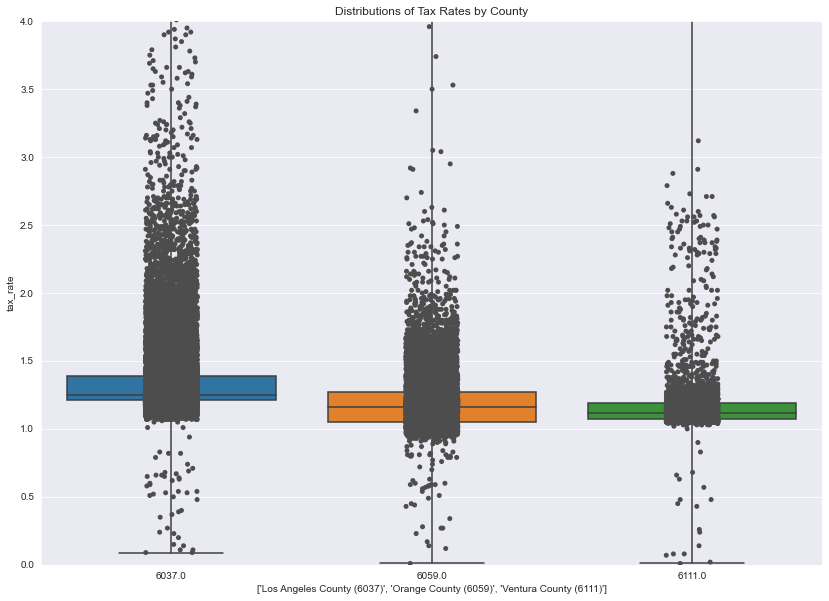

In [90]:
plt.figure(figsize=(14,10))


plt.title("Distributions of Tax Rates by County")
ax = sns.boxplot(x="fips", y="tax_rate", data=tax_df, whis=np.inf)
ax = sns.stripplot(x="fips", y="tax_rate", data=tax_df, color=".3")
ax.set_xlabel(['Los Angeles County (6037)', 'Orange County (6059)', 'Ventura County (6111)'])

ax.set(ylim=(0, 4))